In [649]:
import numpy as np
import pprint as pp
from matplotlib import pyplot as plt
import shutil
import os
import copy
from typing import List, Tuple, Dict, Any
from IPython.display import clear_output

In [650]:
FILENAME = 'kroA100.tsp'
VISUALIZE = True

In [651]:

def read_data_file(file_name: str) -> Dict[Any, Any]:
    tsp_data = {}
    with open(FILENAME, 'r') as file:
        for line in file:
            if line.startswith('EOF'):
                break
            if line.startswith('DIMENSION'):
                tsp_data['DIMENSION'] = int(line.split()[1])
            parts = line.split()
            if parts[0].isdigit():
                node, x, y = map(int, parts)
                tsp_data[node] = (x, y)

    return tsp_data

def calculate_distance_matrix(tsp_data: Dict[Any, Any]) -> np.ndarray:
    N = tsp_data['DIMENSION']
    tsp_data.pop('DIMENSION')

    distance_matrix = [[0 for _ in range(N + 1)] for _ in range(N + 1)]
    for node in tsp_data:
        x1, y1 = tsp_data[node]
        for other_node in tsp_data:
            if node == other_node:
                continue
            else:
                x2, y2 = tsp_data[other_node]
                distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
                distance = round(distance, 2)
                distance_matrix[node][other_node] = distance
                distance_matrix[other_node][node] = distance
    return np.array(distance_matrix)

def print_distance_matrix(distance_matrix: np.ndarray):
    print(distance_matrix)

In [652]:
data = read_data_file('kroA100.tsp')
distance = calculate_distance_matrix(data)
print_distance_matrix(distance)

[[   0.      0.      0.   ...    0.      0.      0.  ]
 [   0.      0.   2606.93 ... 1239.76 1231.55 3117.49]
 [   0.   2606.93    0.   ... 3442.17 1643.61  933.36]
 ...
 [   0.   1239.76 3442.17 ...    0.   2398.07 3679.76]
 [   0.   1231.55 1643.61 ... 2398.07    0.   2406.37]
 [   0.   3117.49  933.36 ... 3679.76 2406.37    0.  ]]


In [653]:
def plot_cities(data: Dict[Any, Any]) -> None:
    x = []
    y = []
    for city in data:
        x.append(data[city][0])
        y.append(data[city][1])
    plt.scatter(x, y)
    plt.show()

def plot_cycles(cycle1: List, cycle2: List, tsp_data: Dict[Any, Any]) -> None:
    x = []
    y = []
    for city in cycle1:
        x.append(tsp_data[city][0])
        y.append(tsp_data[city][1])
    x.append(tsp_data[cycle1[0]][0])
    y.append(tsp_data[cycle1[0]][1])
    plt.plot(x, y, 'ro-')

    x = []
    y = []
    for city in cycle2:
        x.append(tsp_data[city][0])
        y.append(tsp_data[city][1])
    x.append(tsp_data[cycle2[0]][0])
    y.append(tsp_data[cycle2[0]][1])
    plt.plot(x, y, 'bo-')

    plt.show()

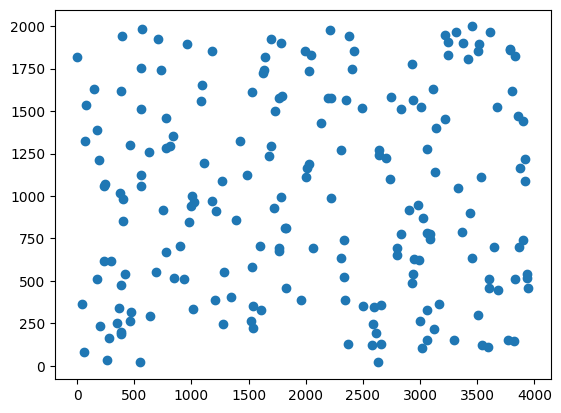

In [654]:
plot_cities(data)

In [655]:
def get_nodes(tsp_data: Dict[Any, Any]) -> np.ndarray:
    nodes = []
    for node in tsp_data:
        if node != 'DIMENSION':
            nodes.append(node)
    return np.array(nodes)

In [656]:
get_nodes(data)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [657]:
def random_cycle(nodes) -> Tuple[np.ndarray, np.ndarray]:
    nodes = copy.deepcopy(nodes)
    np.random.shuffle(nodes)
    half = len(nodes) // 2
    cycle1 = np.array(nodes[:half])
    cycle2 = np.array(nodes[half:])
    
    return cycle1, cycle2

In [658]:
def swap_nodes_between_cycles(cycle1: List, cycle2: List, a_index: int, b_index: int) -> Tuple[np.ndarray, np.ndarray]:
    # cycle1 = copy.deepcopy(cycle1)
    # cycle2 = copy.deepcopy(cycle2)

    tmp = cycle2[b_index]
    cycle2[b_index] = cycle1[a_index]
    cycle1[a_index] = tmp

    return cycle1, cycle2


def swap_edge_within_cycle(cycle: List, a_index: int, b_index: int) -> List:
    # cycle = copy.deepcopy(cycle)
    
    b_index = (b_index + 1) % (len(cycle) + 1)
    if a_index > b_index:
        a_index, b_index = b_index, a_index
    cycle[a_index:b_index] = cycle[a_index:b_index][::-1]
    return cycle

In [659]:
SWAP_NODES_BETWEEN = 2
SWAP_EDGES_WITHIN_CYCLE_1 = 0
SWAP_EDGES_WITHIN_CYCLE_2 = 1

def generate_moves(cycle: List):

    moves = []
    N = len(cycle)

    # generate edges
    for i in range(2, N-1):
        for j in range(N):
            k = (j + i) % (N)
            if j < k:
                moves.append((SWAP_EDGES_WITHIN_CYCLE_1, (j, k)))

    # generate edges
    for i in range(2, N-1):
        for j in range(N):
            k = (j + i) % (N)
            if j < k:
                moves.append((SWAP_EDGES_WITHIN_CYCLE_2, (j, k)))

    # generate nodes
    for i in range(N):
        for j in range(N):
                moves.append((SWAP_NODES_BETWEEN, (i, j)))
    
    # shuffle moves
    np.random.shuffle(moves)
    return moves

In [660]:
def apply_move(move: Tuple[int, Tuple[int, int]], cycle1: List, cycle2: List) -> Tuple[List, List]:
    move_type, (a, b) = move
    
    if move_type == SWAP_NODES_BETWEEN:
        cycle1, cycle2 = swap_nodes_between_cycles(cycle1, cycle2, a, b)

    elif move_type == SWAP_EDGES_WITHIN_CYCLE_1:
        cycle1 = swap_edge_within_cycle(cycle1, a, b)

    elif move_type == SWAP_EDGES_WITHIN_CYCLE_2:
        cycle2 = swap_edge_within_cycle(cycle2, a, b)

    return cycle1, cycle2

In [661]:
def calculate_cycles_length(cycle1: List, cycle2: List, distance_matrix: np.ndarray) -> float:
    c = [cycle1, cycle2]
    total_length = 0
    for cycle in c:
        length = 0
        for i in range(len(cycle)):
            length += distance_matrix[cycle[i-1]][cycle[i]]
        total_length += length

    return round(total_length, 2)

In [662]:
def rank_move(move, cycle1, cycle2):
    subdistance_before = 0
    subdistance_after = 0

    move_type, (A, B) = move

    if move_type == SWAP_NODES_BETWEEN:
        a = cycle1[A]
        b = cycle2[B]

        a_prev = cycle1[(A-1) % len(cycle1)]
        a_next = cycle1[(A+1) % len(cycle1)]

        b_prev = cycle2[(B-1) % len(cycle2)]
        b_next = cycle2[(B+1) % len(cycle2)]

        subdistance_before += distance[a_prev][a] + distance[a][a_next] + distance[b_prev][b] + distance[b][b_next]
        subdistance_after += distance[a_prev][b] + distance[b][a_next] + distance[b_prev][a] + distance[a][b_next]

    elif move_type == SWAP_EDGES_WITHIN_CYCLE_1:
        a = cycle1[A]
        b = cycle1[B]

        a_prev = cycle1[(A-1) % len(cycle1)]
        b_next = cycle1[(B+1) % len(cycle1)]

        subdistance_before += distance[a_prev][a] + distance[b][b_next]
        subdistance_after += distance[a_prev][b] + distance[a][b_next]

    elif move_type == SWAP_EDGES_WITHIN_CYCLE_2:

        a = cycle2[A]
        b = cycle2[B]

        a_prev = cycle2[(A-1) % len(cycle2)]
        b_next = cycle2[(B+1) % len(cycle2)]

        subdistance_before += distance[a_prev][a] + distance[b][b_next]
        subdistance_after += distance[a_prev][b] + distance[a][b_next]

    delta = subdistance_after - subdistance_before
    return round(delta, 2)

In [663]:
def local_search_steepest(cycle1, cycle2, distance):

    # cycle1 = copy.deepcopy(cycle1)
    # cycle2 = copy.deepcopy(cycle2)

    moves = generate_moves(cycle1)

    iter = 0
    while True:

        best_move = None
        best_delta = 0
  
        iter += 1

        for move in moves:

            delta = rank_move(move, cycle1, cycle2)

            if delta < best_delta:
                best_move = move
                best_delta = delta
                

        if best_delta < 0:
            cycle1, cycle2 = apply_move(best_move, cycle1, cycle2)
            if VISUALIZE:
                clear_output(wait=True)
                plot_cycles(cycle1, cycle2, data)
        elif best_move is None:
            break

    return cycle1, cycle2


335042.37


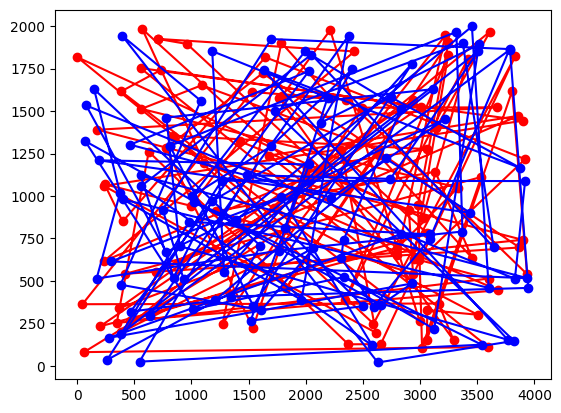

In [664]:
random_cycle1, random_cycle2 = random_cycle(get_nodes(data))

print(calculate_cycles_length(random_cycle1, random_cycle2, distance))
plot_cycles(random_cycle1, random_cycle2, data)

In [665]:
#c1, c2 = local_search_steepest(random_cycle1, random_cycle2, distance)
#plot_cycles(c1, c2, data)
#calculate_cycles_length(c1, c2, distance)

In [666]:
def compute_k_closest_neighbours(distance, k):
    dist = distance[1:, 1:]
    closest = np.argpartition(dist, k+1, axis=1)[:, :k+1] + 1
    zeros = np.zeros(len(closest[0]), dtype=np.uint16)
    return np.concatenate(([zeros], closest))

In [667]:
def find_city(cycle1, cycle2, node):
    
    out = np.where(cycle1 == node)[0]

    if len(out) == 1:
        return (True, out[0])
    else:
        return (False, np.where(cycle2 == node)[0][0])

In [668]:
def candidate_moves_algorithm(cycle1, cycle2, distance, k, data):
    closest = compute_k_closest_neighbours(distance, k)
    num_cities = len(get_nodes(data))
    iter = 0

    while True:
        best_move = None
        best_delta = 0

        for i in range(1, num_cities+1):
            for j in closest[i]:
                if i==j:
                    continue
                i_in_cycle1, pos_i = find_city(cycle1, cycle2, i)
                j_in_cycle1, pos_j = find_city(cycle1, cycle2, j)

                distance_before_succ = 0
                distance_after_succ = 0
                distance_after_pred = 0
                distance_before_pred = 0

                if (i_in_cycle1 and j_in_cycle1):
                    pos_i_succ = (pos_i+1)%len(cycle1)
                    pos_j_succ = (pos_j+1)%len(cycle1)

                    pos_i_pred = (pos_i-1)%len(cycle1)
                    pos_j_pred = (pos_j-1)%len(cycle1)

                    distance_before_succ = distance[i][cycle1[pos_i_succ]] + distance[j][cycle1[pos_j_succ]] # wariant 1
                    distance_after_succ = distance[i][j] + distance[cycle1[pos_i_succ]][cycle1[pos_j_succ]]

                    distance_before_pred = distance[i][cycle1[pos_i_pred]] + distance[j][cycle1[pos_j_pred]] # wariant 2
                    distance_after_pred = distance[i][j] + distance[cycle1[pos_i_pred]][cycle1[pos_j_pred]]

                elif (i_in_cycle1 is False and j_in_cycle1 is False):
                    pos_i_succ = (pos_i+1)%len(cycle2)
                    pos_j_succ = (pos_j+1)%len(cycle2)

                    pos_i_pred = (pos_i-1)%len(cycle2)
                    pos_j_pred = (pos_j-1)%len(cycle2)

                    distance_before_succ = distance[i][cycle2[pos_i_succ]] + distance[j][cycle2[pos_j_succ]]
                    distance_after_succ = distance[i][j] + distance[cycle2[pos_i_succ]][cycle2[pos_j_succ]]

                    distance_before_pred = distance[i][cycle2[pos_i_pred]] + distance[j][cycle2[pos_j_pred]]
                    distance_after_pred = distance[i][j] + distance[cycle2[pos_i_pred]][cycle2[pos_j_pred]]


                delta_succ = distance_after_succ - distance_before_succ
                delta_pred = distance_after_pred - distance_before_pred
                
                delta = min(delta_pred, delta_succ)
                which_delta = np.argmin([delta_succ, delta_pred])

                if best_delta > delta:
                    best_delta = delta
                    
                    if which_delta == 0:
                        pos = (pos_i_succ, pos_j)
                    elif which_delta == 1:
                        pos = (pos_i, pos_j_pred)
                        
                    if (i_in_cycle1 and j_in_cycle1):
                        best_move = (SWAP_EDGES_WITHIN_CYCLE_1, pos)
                    elif (i_in_cycle1 is False and j_in_cycle1 is False):
                        best_move = (SWAP_EDGES_WITHIN_CYCLE_2, pos)
                        
        if best_move is None:
            break

        cycle1, cycle2 = apply_move(best_move, cycle1, cycle2)
        if VISUALIZE:
            clear_output(wait=True)
            plot_cycles(cycle1, cycle2, data)
        iter += 1
    
    return (cycle1, cycle2)

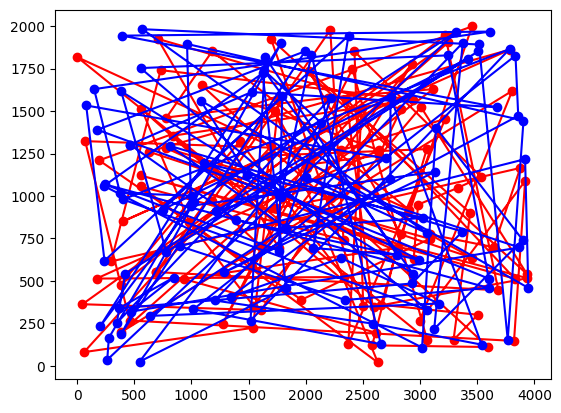

In [669]:
random_cycle1, random_cycle2 = random_cycle(get_nodes(data))
plot_cycles(random_cycle1, random_cycle2, data)

In [670]:
# c1, c2 = candidate_moves_algorithm(random_cycle1, random_cycle2, distance, 10, data)
# calculate_cycles_length(c1, c2, distance)
# plot_cycles(c1, c2, data)

In [671]:
def generate_cache_moves(cycle, move_type):
    edges = []
    combinations = []
    for i in range(len(cycle)-1):
        j = (i + 1) % len(cycle)
        edge = (cycle[i], cycle[j])
        coords = (i, j)
        edges.append((edge, coords))

    for i in range(len(edges)):
        for j in range(len(edges)):
            if i == j:
                continue
            (a, b), coords_0 = edges[i]
            (c, d), coords_1 = edges[j]
            if a == c or a == d or b == c or b == d:
                continue
            move = (move_type, (coords_0[1], coords_1[0]))
            combinations.append(((a,b), (c,d), move))

    return combinations

def generate_all_cache_moves(cycle1, cycle2):
    moves = []
    moves.extend(generate_cache_moves(cycle1, SWAP_EDGES_WITHIN_CYCLE_1))
    moves.extend(generate_cache_moves(cycle2, SWAP_EDGES_WITHIN_CYCLE_2))
    return moves



In [672]:
def rank_move_coords(cycle1, cycle2, move_with_coords):
    (a, b), (c, d), move = move_with_coords
    return (a, b), (c, d), move, rank_move(move, cycle1, cycle2)


def rank_moves(moves_with_coords, cycle1, cycle2):
    moves_with_coords = sorted(
        filter(lambda x: x[3] < 0,
               map(lambda x: (*x, rank_move(x[2], cycle1, cycle2)), moves_with_coords)
        ),
        key=lambda x: x[3]
    )
    return moves_with_coords



In [673]:
def find_node_in_cycle(node, cycle):
    for i in range(len(cycle)):
        if cycle[i] == node:
            return i
    return -1

def find_edge_in_cycle(edge, cycle):
    a = edge[0]
    b = edge[1]
    for i in range(len(cycle)):
        if cycle[i] == a and cycle[(i+1) % len(cycle)] == b:
            return True
        elif cycle[i] == b and cycle[(i+1) % len(cycle)] == a:
            return True
    return False

def find_edges_in_cycle(edge1, edge2, cycle):
    if find_edge_in_cycle(edge1, cycle) and find_edge_in_cycle(edge2, cycle):
        return True

def remove_marked(moves, banned_edged):
    valid_moves = []
    for m in moves:
        (a, b), (c, d), move, _ = m
        move_type, (a_index, b_index) = move
        if (a, b) not in banned_edged and (c, d) not in banned_edged:
            valid_moves.append(m)
    return valid_moves



def cache_moves_algorithm(cycle1, cycle2, data):
    init_possible_moves = generate_all_cache_moves(cycle1, cycle2)
    ranked_moves = rank_moves(init_possible_moves, cycle1, cycle2)
    print(f"Ruchy: {ranked_moves}")

    while True:
  
        appliable_move = None
        banned_edged = set()

        for ranked_move in ranked_moves:
            (a, b), (c, d), move, rank = ranked_move
            move_type, (_, _) = move

            edges_in_c1, edges_in_c2, reversed_edges_in_c1, reversed_edges_in_c2 = False, False, False, False

            if move_type == SWAP_EDGES_WITHIN_CYCLE_1:
                edges_in_c1 = find_edges_in_cycle((a, b), (c, d), cycle1)
                reversed_edges_in_c1 = find_edges_in_cycle((b, a), (c, d), cycle1)

            if move_type == SWAP_EDGES_WITHIN_CYCLE_2: 
                edges_in_c2 = find_edges_in_cycle((a, b), (c, d), cycle2)
                reversed_edges_in_c2 = find_edges_in_cycle((b, a), (c, d), cycle2)

            if edges_in_c1:
                # print(f"Edges in cycle 1: {a} {b} {c} {d}")
                appliable_move = move
                banned_edged.add((a, b))
                banned_edged.add((c, d))
                banned_edged.add((a, c))
                banned_edged.add((b, d))
                break

            if edges_in_c2:
                # print(f"Edges in cycle 2: {a} {b} {c} {d}")
                appliable_move = move
                banned_edged.add((a, b))
                banned_edged.add((c, d))
                banned_edged.add((a, c))
                banned_edged.add((b, d))
                break

            if reversed_edges_in_c1 or reversed_edges_in_c2:
                # print(f"Reversed edges in cycle 1: {a} {b} {c} {d}")
                appliable_move = None

            if not (reversed_edges_in_c1 or reversed_edges_in_c2):
                # print("No reversed edges in cycles")
                banned_edged.add((a, b))
                banned_edged.add((c, d))

            if not (edges_in_c1 or edges_in_c2):
                # print("No edges in cycles")
                banned_edged.add((a, b))
                banned_edged.add((c, d))

        if appliable_move is None:
            break
        else:
            move_type, (a_index, b_index) = appliable_move
            move = move_type, (a_index, b_index)
            pre = calculate_cycles_length(cycle1, cycle2, distance)

            if move_type == SWAP_EDGES_WITHIN_CYCLE_1:
                pp.pprint(cycle1)
            else:
                pp.pprint(cycle2)

            cycle1, cycle2 = apply_move(move, cycle1, cycle2)


            if move_type == SWAP_EDGES_WITHIN_CYCLE_1:
                pp.pprint(cycle1)
            else:
                pp.pprint(cycle2)
            print(f"a: {a}, b: {b}, c: {c}, d: {d}, Move: {move}")
            post = calculate_cycles_length(cycle1, cycle2, distance)
            print(f"Pre: {pre} Post: {post} Delta: {round(post - pre, 2)}, Rank: {rank}")

            # if VISUALIZE:
            #     clear_output(wait=True)
            #     plot_cycles(cycle2, cycle1, data)
            
            # print(f"Length of moves: {len(ranked_moves)}")
            ranked_moves = remove_marked(ranked_moves, banned_edged)
            # print(f"Length of moves: {len(ranked_moves)}")


    return cycle1, cycle2

        

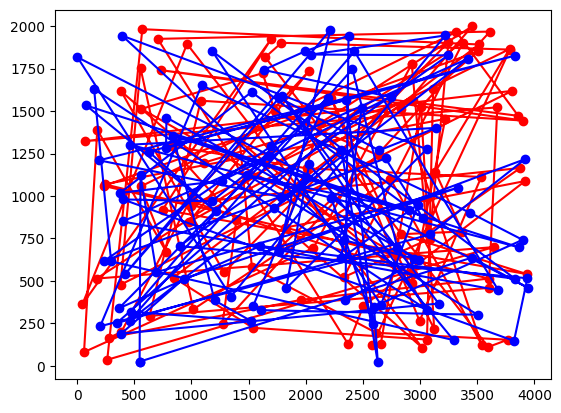

In [674]:
random_cycle1, random_cycle2 = random_cycle(get_nodes(data))
plot_cycles(random_cycle1, random_cycle2, data)


In [675]:
c1, c2 = cache_moves_algorithm(random_cycle1, random_cycle2, data)


Ruchy: [((198, 51), (170, 110), (1, (3, 21)), -6686.0), ((170, 110), (198, 51), (1, (22, 2)), -6686.0), ((198, 51), (67, 155), (1, (3, 10)), -6427.36), ((67, 155), (198, 51), (1, (11, 2)), -6427.36), ((31, 158), (187, 8), (0, (15, 57)), -6423.75), ((187, 8), (31, 158), (0, (58, 14)), -6423.75), ((187, 8), (41, 136), (0, (58, 67)), -6164.26), ((41, 136), (187, 8), (0, (68, 57)), -6164.26), ((3, 31), (158, 36), (0, (14, 15)), -6157.62), ((158, 36), (3, 31), (0, (16, 13)), -6157.62), ((67, 155), (170, 110), (1, (11, 21)), -6097.22), ((170, 110), (67, 155), (1, (22, 10)), -6097.22), ((33, 93), (31, 158), (0, (9, 14)), -5950.29), ((31, 158), (33, 93), (0, (15, 8)), -5950.29), ((158, 36), (189, 41), (0, (16, 66)), -5939.58), ((189, 41), (158, 36), (0, (67, 15)), -5939.58), ((31, 158), (41, 136), (0, (15, 67)), -5904.0), ((41, 136), (31, 158), (0, (68, 14)), -5904.0), ((3, 31), (95, 126), (0, (14, 43)), -5847.58), ((95, 126), (3, 31), (0, (44, 13)), -5847.58), ((11, 33), (3, 31), (0, (8, 13))